In [6]:
#Importing required libraries
import numpy as np
import random
from decimal import Decimal, ROUND_DOWN
import cmath
import time
import pylab as pl
from IPython import display

%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
#Physical properties
wavelength = 813.4e-9   
focal_dist = 4e-3       #focal length of the lens
beam_width = 2e-3       #radius of the input beam
aperture = 4e-3         #aperture diameter of the lens


#Simulation variables
xmin = -5.28e-3   # Simulating SLM grid
xmax = 5.28e-3
ymin = -5.28e-3
ymax = 5.28e-3
xlen = xmax-xmin  #calculating total length, later used to find dx
ylen = ymax-ymin


N = 1152      #X-Size of the matrix for performing simulation
M = 1152      #Y-Size of the matrix for performing simulation

dx = xlen/N   #X-Sampling size
dy = ylen/M   #Y-Sampling size

print(dx,dy)

x = np.arange(xmin,xmax,dx)   #X-line_space
y = np.arange(ymin,ymax,dy)   #Y-line_space


X,Y = np.meshgrid(x,y)   #defining meshgrid

9.166666666666666e-06 9.166666666666666e-06


In [8]:
normalizing_factor = (1e-3/((np.pi*beam_width**2)/2))   #normalzing to 1mW power
input_beam = normalizing_factor*np.exp(-2*((X/beam_width)**2 + (Y/(beam_width))**2))  #Intensity

In [9]:
inp_power = np.trapz(np.trapz(input_beam))*dx*dy  #1mW power (Integration of Intensity)
print('Input power = ' + str(1e3*inp_power) + ' mW')

Input power = 0.9999997349569626 mW


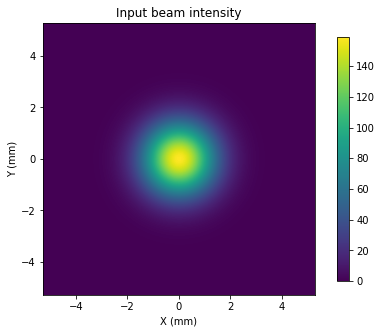

In [10]:
slicing = 00
extent = [(xmin + slicing*dx)*1e3, (xmax - slicing*dx)*1e3,(ymin + slicing*dy)*1e3,(ymax - slicing*dy)*1e3]
plt.figure(figsize=(8,5))
plt.title('Input beam intensity')
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.xticks(np.arange(-10,11,2))
plt.yticks(np.arange(-10,11,2))
plt.imshow((input_beam)[slicing:N-slicing,slicing:M-slicing],extent = extent,origin = 'lower')
plt.colorbar(shrink=0.9)

In [11]:
def fraunhofer(inp,xlen,ylen,wavelen,z):
    M,N = inp.shape

    dx = xlen/N    #finding sampling size
    dy = ylen/M
    
    k = 2*np.pi/wavelen  #wave-vector

    LX = wavelen*z/dx    #Calculating image plane X-Len 
    LY = wavelen*z/dy    #Calculating image plane Y-Len

    DX = wavelen*z/xlen  #Calculating image plane X-Sampling
    DY = wavelen*z/ylen  #Calculating image plane Y-Sampling
    
    x2 = np.arange(-LX/2,LX/2-(DX/2),DX)
    y2 = np.arange(-LY/2,LY/2-(DY/2),DY)
    
    X2,Y2 = np.meshgrid(x2,y2)  #meshgrid for image plane

    exp_term = 1/(1j*wavelen*z)
    
    outp = exp_term*np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(inp)))*dx*dy

    
    #print('X & Y side lengths = ' + str(LX) +' ' + str(LY))
    #print('X & Y sampling size = ' + str(DX) +' ' + str(DY))
    
    return outp,LX,LY,DX,DY,x2,y2

In [12]:
PSF,LX,LY,DX,DY,x2,y2 = fraunhofer((input_beam**0.5),xlen,ylen,wavelength,focal_dist) #Point spread function

In [13]:
spots = []      #array to store position of desired focused spot
for i in range(-5,5):
    for j in range(-5,5):
        spots.append([3e-6*i + 1.5e-6,3e-6*j + 1.5e-6])

In [14]:
#function to convolute PSF with targets 1s
def GenerateTargetWithDistance(PSF,spots,xlen,ylen,factor):  
    M,N = PSF.shape     #storing array size
    dx = xlen/N         #computing sampling size
    dy = ylen/M
    #print(dx,dy)
    conv = np.zeros(PSF.shape)  #frame of 1s that'll be convoluted with PSF
    for i in range(len(spots)):
        x,y = spots[i]          #extracting coordinates
        posX = int(x/dx) + int(N/2)   #finding X & Y postion
        posY = int(y/dy) + int(M/2)
        conv[posY,posX] = factor[i]   #replacing 0 with a normalized factor
        
    fin = np.fft.ifftshift(np.fft.ifft2(np.fft.fft2(np.fft.fftshift(PSF))*np.fft.fft2(np.fft.fftshift(conv)))) #convolution
    return fin


In [15]:
target_profile = GenerateTargetWithDistance(PSF,spots,LX,LY,np.ones(len(spots))/np.sqrt(len(spots))) #generating target profile
spot_index = np.where(abs(target_profile**2) >= 0.99*abs(target_profile**2).max())    #Calculating the nearest possible peaks
print('Total peaks = ' + str(len(spot_index[0])))   #Checking for number of peaks


Total peaks = 100


In [16]:
def GenerateTargetWithIndex(PSF,spot_index,xlen,ylen,factor):
    M,N = PSF.shape #storing array size
    
    conv = np.zeros(PSF.shape)   #frame of 1s that'll be convoluted with PSF
    
    for i in range(len(spot_index[0])):
        conv[spot_index[0][i]][spot_index[1][i]] = factor[i]    #replacing 0 with normalized factor
    
    fin = np.fft.ifftshift(np.fft.ifft2(np.fft.fft2(np.fft.fftshift(PSF))*np.fft.fft2(np.fft.fftshift(conv)))) #convolution
    return fin

In [17]:
target_profile = GenerateTargetWithIndex(PSF,spot_index,xlen,ylen,
                                         np.ones(len(spots))/np.sqrt(len(spots))) #generating target profile

In [18]:
def Efficiency(beam,spot_index,size,DX,DY):    #To calculate the efficiency of the focused spots
    power_out = 0         #to store the total output power
    for i in range(len(spot_index[0])):     #iterating over each spot
        #Summing over a grid of size = size to find the power
        power_out = power_out + np.trapz(np.trapz(abs(beam**2)[spot_index[0][i]-size:spot_index[0][i]+size,spot_index[1][i]-size:spot_index[1][i]+size]))*DX*DY
    return power_out

def GetStatistics(beam,spot_index):
    subtraction = abs(beam**2)[spot_index].max() - abs(beam**2)[spot_index].min()  #numerator to calculate uniformity
    addition = (abs(beam**2)[spot_index].max() + abs(beam**2)[spot_index].min())   #denominator to calculate uniformity
    uniformity = 1 - subtraction/addition   #Uniformity
    
    mean_int = abs(beam**2)[spot_index].mean() #mean intensity
    max_int = abs(beam**2)[spot_index].max()   #maximum intensity
    min_int = abs(beam**2)[spot_index].min()   #minimum intensity
    std_dev = abs(beam**2)[spot_index].std()   #standard deviation of intensities
    
    return mean_int,max_int/mean_int,min_int/mean_int,std_dev/mean_int,uniformity #returning values normalized to mean intensity

In [19]:
Efficiency(target_profile,spot_index,4,DX,DY)/inp_power  #to check the value of size works correctly

0.9991697341376771

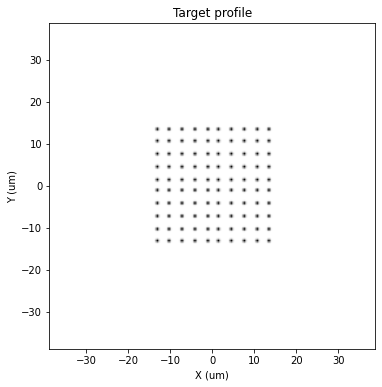

In [21]:
slicing = 450
plt.figure(figsize=(6,6))
extent = [(-LX/2 + slicing*DX)*1e6, (LX/2 - slicing*DX)*1e6,(-LY/2 + slicing*DY)*1e6,(LY/2 - slicing*DY)*1e6]
plt.title('Target profile')
plt.xlabel('X (um)')
plt.ylabel('Y (um)')
plt.xticks(np.arange(-100,101,10))
plt.yticks(np.arange(-100,101,10))
plt.imshow(-abs(target_profile**2)[slicing:target_profile.shape[0]-slicing,slicing:target_profile.shape[1]-slicing],extent = extent,origin='lower',cmap='gray')

In [22]:
def GS(f,xlen,ylen,wavelen,z,F,max_iter,phi,spot_index):
    
    n,m = f.shape        #storing the size of input
    
    x = f*np.exp(1j*phi) #Complex amplitude of the input beam
    
    ephase = phi         #Estimated phi (Changes on each iteration)
    
    k = 0                #loop variable

    while(k<max_iter):   #looping for max_iterations
        
        X,LX,LY,DX,DY,x2,y2 = fraunhofer(x,xlen,ylen,wavelen,z)    #FT to image plane
                        
        new_x,xlen_new,ylen_new,dx_new,dy_new,x_new,y_new = fraunhofer(F*np.exp(1j*np.angle(X)),LX,LY,wavelen,z) #IFT to object plane (-ve of FT)
                
        ephase = -np.angle(new_x)  #negative sign because 2 FT [instead of FT & IFT] (storing the retrieved phase)

        x = f*np.exp(1j*ephase)    #new complex amplitude of the input beam

        k = k + 1        
        
        ###############################Iterative Plots######################################################
        in_between,LX,LY,DX,DY,x2,y2 = fraunhofer(x,xlen,ylen,wavelen,z)
        plt.clf()
        plt.title('Peak values')
        plt.xlabel('peak number')
        plt.ylabel('Intensity')
        plt.xticks(np.arange(0,len(spot_index[0])+1,0.2*len(spot_index[0])))
        plt.ylim(0,3e9/len(spot_index[0]))
        pl.plot(abs(in_between**2)[spot_index],color='blue')
        pl.axhline(y= abs(in_between**2)[spot_index].mean(),linestyle='dashed',color='black')
        display.display(pl.gcf())
        display.clear_output(wait=True)
        time.sleep(0.1)
        ####################################################################################################
    
    return ephase  #returning only the final estimated phase

In [23]:
def wGS(f,xlen,ylen,wavelen,z,F,max_iter,phi,spot_index):
    
    n,m = f.shape        #storing the size of input
    
    x = f*np.exp(1j*phi) #Complex amplitude of the input beam
    
    ephase = phi         #Estimated phi (Changes on each iteration)
        
    k = 0                #loop variable

    wfactor = np.ones(len(spot_index[0]))  #weight factor

    while(k<max_iter):   #looping for max_iterations
        
        X,LX,LY,DX,DY,x2,y2 = fraunhofer(x,xlen,ylen,wavelen,z)  #FT to image plane

        CurrPeaks = abs(X[spot_index])      #Extracting current peak values
        
        wfactor = wfactor*(CurrPeaks.mean()/CurrPeaks)   #changing weight factor at each iteration
            
        F = GenerateTargetWithIndex(PSF,spot_index,LX,LY,wfactor/np.sqrt(sum(np.asarray(wfactor)**2))) #new target profile
            
        new_x,xlen_new,ylen_new,dx_new,dy_new,x_new,y_new = fraunhofer(F*np.exp(1j*np.angle(X)),LX,LY,wavelen,z) #IFT to object plane (-ve of FT)
         
        ephase = -np.angle(new_x)  #negative sign beacuse we took 2FT (instead of FT and IFT)
            
        x = f*np.exp(1j*ephase)    #new complex amplitude of the input beam
        
        k = k + 1
        
        ###############################Iterative Plots######################################################
        in_between,LX,LY,DX,DY,x2,y2 = fraunhofer(x,xlen,ylen,wavelength,focal_dist)
        plt.clf()
        plt.title('Peak values')
        plt.xlabel('peak number')
        plt.ylabel('Intensity')
        plt.xticks(np.arange(0,len(spot_index[0])+1,0.2*len(spot_index[0])))
        plt.ylim(0,3e9/len(spot_index[0]))
        pl.plot(abs(in_between**2)[spot_index],color='blue')
        pl.axhline(y= abs(in_between**2)[spot_index].mean(),linestyle='dashed',color='black')
        display.display(pl.gcf())
        display.clear_output(wait=True)
        time.sleep(0.1)
        ####################################################################################################

    return  ephase  #returning only the final estimated phase

In [24]:
def wGSModified(f,xlen,ylen,wavelen,z,F,max_iter,phi,spot_index):
    
    n,m = f.shape        #storing the size of input
    
    x = f*np.exp(1j*phi) #Complex amplitude of the input beam
    
    ephase = phi         #Estimated phi (Changes on each iteration)
    
    stagnant_phase = phi #used after 32 iterations
    
    k = 0                #loop variable

    wfactor = np.ones(len(spot_index[0]))  #weight factor

    while(k<max_iter):   #looping for max_iterations
        
        X,LX,LY,DX,DY,x2,y2 = fraunhofer(x,xlen,ylen,wavelen,z)  #FT to image plane

        CurrPeaks = abs(X[spot_index])      #Extracting current peak values
        
        wfactor = wfactor*(CurrPeaks.mean()/CurrPeaks)   #changing weight factor at each iteration
            
        F = GenerateTargetWithIndex(PSF,spot_index,LX,LY,wfactor/np.sqrt(sum(np.asarray(wfactor)**2))) #new target profile
            
        new_x,xlen_new,ylen_new,dx_new,dy_new,x_new,y_new = fraunhofer(F*np.exp(1j*np.angle(X)),LX,LY,wavelen,z) #IFT to object plane (-ve of FT)
         
        if(k==32):
            stagnant_phase = np.angle(X)
            
        if(k>32):
            new_x,xlen_new,ylen_new,dx_new,dy_new,x_new,y_new = fraunhofer(F*np.exp(1j*stagnant_phase),LX,LY,wavelen,z) #IFT to object plane (-ve of FT)

        ephase = -np.angle(new_x)  #negative sign beacuse we took 2FT (instead of FT and IFT)
            
        x = f*np.exp(1j*ephase)    #new complex amplitude of the input beam
        
        k = k + 1
        
        ###############################Iterative Plots######################################################
        in_between,LX,LY,DX,DY,x2,y2 = fraunhofer(x,xlen,ylen,wavelength,focal_dist)
        plt.clf()
        plt.title('Peak values')
        plt.xlabel('peak number')
        plt.ylabel('Intensity')
        plt.xticks(np.arange(0,len(spot_index[0])+1,0.2*len(spot_index[0])))
        plt.ylim(0,3e9/len(spot_index[0]))
        pl.plot(abs(in_between**2)[spot_index],color='blue')
        pl.axhline(y= abs(in_between**2)[spot_index].mean(),linestyle='dashed',color='black')
        display.display(pl.gcf())
        display.clear_output(wait=True)
        time.sleep(0.1)
        ####################################################################################################

    return  ephase  #returning only the final estimated phase

In [25]:
phi = 2*np.pi*np.random.rand(target_profile.shape[0],target_profile.shape[1])-np.pi #Random phase from -pi to pi

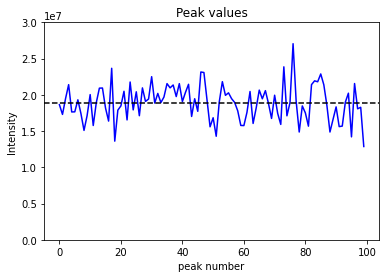

In [26]:
max_iter = 50      #defining maximum iterations
ephase = GS((abs(input_beam)**0.5),xlen,ylen,wavelength,focal_dist,abs(target_profile),
            max_iter,phi,spot_index)   #Calling GS and saving the final estimated phase

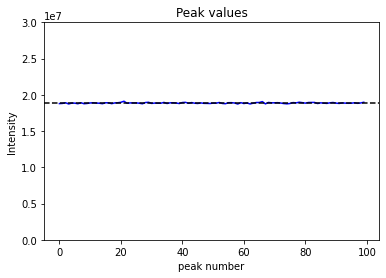

In [28]:
max_iter = 50
ephasew = wGS((abs(input_beam)**0.5),xlen,ylen,wavelength,focal_dist,abs(target_profile),
              max_iter,phi,spot_index)   #Calling wGS and saving the final estimated phase

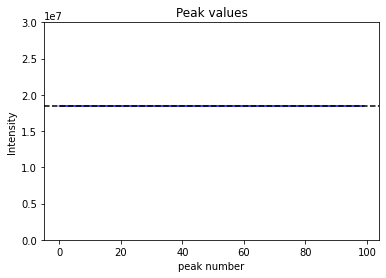

In [29]:
max_iter = 50
ephasewm = wGSModified((abs(input_beam)**0.5),xlen,ylen,wavelength,focal_dist,abs(target_profile),
              max_iter,phi,spot_index)   #Calling wGS and saving the final estimated phase

In [30]:
focused_beam,LX,LY,DX,DY,x2,y2 = fraunhofer((input_beam**0.5)*np.exp(1j*ephase),xlen,ylen,wavelength,focal_dist)
focused_beamw,LX,LY,DX,DY,x2,y2 = fraunhofer((input_beam**0.5)*np.exp(1j*ephasew),xlen,ylen,wavelength,focal_dist)
focused_beamwm,LX,LY,DX,DY,x2,y2 = fraunhofer((input_beam**0.5)*np.exp(1j*ephasewm),xlen,ylen,wavelength,focal_dist)

stats = GetStatistics(focused_beam,spot_index)  #Printing stats for GS
print('GS:')
print('Max        : %.2f'%(100*stats[1]))
print('Min        : %.2f'%(100*stats[2]))
print('Stdev      : %.2f'%(100*stats[3]))
print('Uniformity : %.2f'%(100*stats[4]))
print('Efficiency : %.2f'%(100*Efficiency(focused_beam,spot_index,4,DX,DY)/inp_power))  

statsw = GetStatistics(focused_beamw,spot_index)  #Printing stats for wGS
print('\nwGS:')
print('Max        : %.2f'%(100*statsw[1]))
print('Min        : %.2f'%(100*statsw[2]))
print('Stdev      : %.2f'%(100*statsw[3]))
print('Uniformity : %.2f'%(100*statsw[4]))
print('Efficiency : %.2f'%(100*Efficiency(focused_beamw,spot_index,4,DX,DY)/inp_power))

statswm = GetStatistics(focused_beamwm,spot_index)   #Printing stats for wGSModified
print('\nwGS Modified:')
print('Max        : %.2f'%(100*statswm[1]))
print('Min        : %.2f'%(100*statswm[2]))
print('Stdev      : %.2f'%(100*statswm[3]))
print('Uniformity : %.2f'%(100*statswm[4]))
print('Efficiency : %.2f'%(100*Efficiency(focused_beamwm,spot_index,4,DX,DY)/inp_power))

GS:
Max        : 143.24
Min        : 68.14
Stdev      : 13.11
Uniformity : 64.47
Efficiency : 92.24

wGS:
Max        : 101.32
Min        : 99.27
Stdev      : 0.36
Uniformity : 98.98
Efficiency : 92.07

wGS Modified:
Max        : 100.00
Min        : 100.00
Stdev      : 0.00
Uniformity : 100.00
Efficiency : 91.65


In [ ]:
plt.figure(figsize =(8,5))
plt.xlabel('Intensity (arb units)')
plt.ylabel('Occurences')
plt.ylim(0,60)
plt.title('Peak value distribution')
#histogram of intensity distribution with binsize = 1
plt.hist(100*abs(focused_beam**2)[spot_index]/stats[0],bins = np.arange(55,145,1),color = 'red',alpha = 0.5,label='GS')
plt.hist(100*abs(focused_beamw**2)[spot_index]/statsw[0],bins = np.arange(55,145,1),color= 'blue',alpha = 0.5,label='wGS')
plt.legend()

In [ ]:
plt.figure(figsize =(8,5))
plt.xlabel('Intensity (arb units)')
plt.ylabel('Occurences')
plt.ylim(0,60)
plt.title('Peak value distribution')
#histogram of intensity distribution with binsize = 0.05
plt.hist(100*abs(focused_beamw**2)[spot_index]/statsw[0],bins = np.arange(98,102,0.05),color= 'red',alpha = 0.5,label='wGS')
plt.hist(100*abs(focused_beamwm**2)[spot_index]/statswm[0],bins = np.arange(98,102,0.05),color= 'blue',alpha = 0.5,label='wGSModified')
plt.legend()

In [ ]:
slicing = 0
extent = [(xmin + slicing*dx)*1e3, (xmax - slicing*dx)*1e3,(ymin + slicing*dy)*1e3,(ymax - slicing*dy)*1e3]
plt.figure(figsize=(8,5))
plt.title('Final Phase')
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.xticks(np.arange(-10,11,2))
plt.yticks(np.arange(-10,11,2))
plt.imshow(ephasewm,cmap='gray',extent = extent,origin = 'left')
plt.colorbar(shrink=0.9)

In [ ]:
xmin = -3*5.28e-3     #increasing the field of view (FOV) for better resolution
xmax = 3*5.28e-3
ymin = -3*5.28e-3
ymax = 3*5.28e-3
xlen = xmax-xmin
ylen = ymax-ymin

N = 3*1152            #new array size
M = 3*1152

dx = (xmax-xmin)/N     #dx is still the same, because we have increased FOV and array size in equal proportion
dy = (ymax-ymin)/M
print(dx,dy)
x = np.arange(xmin,xmax-dx/2,dx)
y = np.arange(ymin,ymax-dy/2,dy)


X,Y = np.meshgrid(x,y)

input_beam = (1e-3/((np.pi*beam_width**2)/2))*np.exp(-2*((X/beam_width)**2 + (Y/(beam_width))**2))

final_phi = np.zeros(input_beam.shape)
final_phiw = np.zeros(input_beam.shape)
final_phiwm = np.zeros(input_beam.shape)

final_phi[1152:2*1152,1152:2*1152] = ephase          #padding th out phase with zeros
final_phiw[1152:2*1152,1152:2*1152] = ephasew
final_phiwm[1152:2*1152,1152:2*1152] = ephasewm

#Since dx is same, LX also remains the same, but with increased FOV, DX decreases (better resolution) so spot indices change
new_spot_index = spot_index[0]*3,spot_index[1]*3    

In [ ]:
#focusing input beam with retrieved GS phase
focused_beam,LX,LY,DX,DY,x2,y2 = fraunhofer((input_beam**0.5)*np.exp(1j*final_phi),
                                             xlen,ylen,wavelength,focal_dist)

slicing = 1400
plt.figure(figsize=(6,6))
extent = [(-LX/2 + slicing*DX)*1e6, (LX/2 - slicing*DX)*1e6,(-LY/2 + slicing*DY)*1e6,(LY/2 - slicing*DY)*1e6]
plt.title('Retrieved profile (Intensity)')
plt.xlabel('X (um)')
plt.ylabel('Y (um)')
plt.xticks(np.arange(-300,301,10))
plt.yticks(np.arange(-300,301,10))
plt.imshow(-abs(focused_beam**2)[slicing:M-slicing,slicing:N-slicing],extent = extent,aspect='auto',origin='left',cmap='gray')

In [ ]:
#focusing input beam with retrieved wGS phase
focused_beamw,LX,LY,DX,DY,x2,y2 = fraunhofer((input_beam**0.5)*np.exp(1j*final_phiw),
                                             xlen,ylen,wavelength,focal_dist)

slicing = 1400
plt.figure(figsize=(6,6))
extent = [(-LX/2 + slicing*DX)*1e6, (LX/2 - slicing*DX)*1e6,(-LY/2 + slicing*DY)*1e6,(LY/2 - slicing*DY)*1e6]
plt.title('Retrieved profile (Intensity)')
plt.xlabel('X (um)')
plt.ylabel('Y (um)')
plt.xticks(np.arange(-300,301,10))
plt.yticks(np.arange(-300,301,10))
plt.imshow(-abs(focused_beamw**2)[slicing:M-slicing,slicing:N-slicing],extent = extent,aspect='auto',origin='left',cmap='gray')


In [ ]:
#focusing input beam with retrieved wGS phase
focused_beamwm,LX,LY,DX,DY,x2,y2 = fraunhofer((input_beam**0.5)*np.exp(1j*final_phiwm),
                                             xlen,ylen,wavelength,focal_dist)

slicing = 1400
plt.figure(figsize=(6,6))
extent = [(-LX/2 + slicing*DX)*1e6, (LX/2 - slicing*DX)*1e6,(-LY/2 + slicing*DY)*1e6,(LY/2 - slicing*DY)*1e6]
plt.title('Retrieved profile (Intensity)')
plt.xlabel('X (um)')
plt.ylabel('Y (um)')
plt.xticks(np.arange(-300,301,10))
plt.yticks(np.arange(-300,301,10))
plt.imshow(-abs(focused_beamwm**2)[slicing:M-slicing,slicing:N-slicing],extent = extent,aspect='auto',origin='left',cmap='gray')


In [ ]:
#Stats remain the same for new sampling (only efficiency changes because the resolution changes)
#Other quantitites remains the same (becuase they are mean normalized)
stats = GetStatistics(focused_beam,new_spot_index)  
print('GS:')
print('Max        : %.2f'%(100*stats[1]))
print('Min        : %.2f'%(100*stats[2]))
print('Stdev      : %.2f'%(100*stats[3]))
print('Uniformity : %.2f'%(100*stats[4]))
print('Efficiency : %.2f'%(100*Efficiency(focused_beam,new_spot_index,12,DX,DY)/inp_power))

statsw = GetStatistics(focused_beamw,new_spot_index)
print('\nwGS:')
print('Max        : %.2f'%(100*statsw[1]))
print('Min        : %.2f'%(100*statsw[2]))
print('Stdev      : %.2f'%(100*statsw[3]))
print('Uniformity : %.2f'%(100*statsw[4]))
print('Efficiency : %.2f'%(100*Efficiency(focused_beamw,new_spot_index,12,DX,DY)/inp_power))

statswm = GetStatistics(focused_beamwm,new_spot_index)
print('\nwGS Modified:')
print('Max        : %.2f'%(100*statswm[1]))
print('Min        : %.2f'%(100*statswm[2]))
print('Stdev      : %.2f'%(100*statswm[3]))
print('Uniformity : %.2f'%(100*statswm[4]))
print('Efficiency : %.2f'%(100*Efficiency(focused_beamwm,new_spot_index,12,DX,DY)/inp_power))

## TQT using optical tweezers

In [ ]:
xmin = -5.28e-3   # Simulating SLM grid
xmax = 5.28e-3
ymin = -5.28e-3
ymax = 5.28e-3
xlen = xmax-xmin  #calculating total length, later used to find dx
ylen = ymax-ymin


N = 1152      #X-Size of the matrix for performing simulation
M = 1152      #Y-Size of the matrix for performing simulation

dx = xlen/N   #X-Sampling size
dy = ylen/M   #Y-Sampling size

print(dx,dy)

x = np.arange(xmin,xmax,dx)   #X-line_space
y = np.arange(ymin,ymax,dy)   #Y-line_space


X,Y = np.meshgrid(x,y)   #defining meshgrid

input_beam = (1e-3/((np.pi*beam_width**2)/2))*np.exp(-2*((X/beam_width)**2 + (Y/(beam_width))**2))

In [ ]:
spots = [[-35e-6,10e-6],[-30e-6,10e-6],[-25e-6,10e-6],[-20e-6,10e-6],[-15e-6,10e-6],
        [-25e-6,10e-6],[-25e-6,5e-6],[-25e-6,0],[-25e-6,-5e-6],[-25e-6,-10e-6],
        [35e-6,10e-6],[30e-6,10e-6],[25e-6,10e-6],[20e-6,10e-6],[15e-6,10e-6],
        [25e-6,10e-6],[25e-6,5e-6],[25e-6,0],[25e-6,-5e-6],[25e-6,-10e-6],
        [0,10e-6],[0,-10e-6],[-6e-6,8e-6],[6e-6,8e-6],[-3.5e-6,9e-6],[3.5e-6,9e-6],
        [-8.2e-6,6e-6],[8.2e-6,6e-6],[-9.7e-6,3e-6],[9.7e-6,3e-6],[-10e-6,0],[10e-6,0],
        [-6e-6,-8e-6],[6e-6,-8e-6],[-3.5e-6,-9e-6],[3.5e-6,-9e-6],
        [-8.2e-6,-6e-6],[8.2e-6,-6e-6],[-9.7e-6,-3e-6],[9.7e-6,-3e-6],
        [4e-6,-6e-6],[8e-6,-10e-6],[10e-6,-12e-6]]

In [ ]:
target_profile = GenerateTargetWithDistance(PSF,spots,LX,LY,np.ones(len(spots))/np.sqrt(len(spots)))
spot_index = np.where(abs(target_profile**2) >= 0.99*abs(target_profile**2).max())
len(spot_index[0])

In [ ]:
target_profile = GenerateTargetWithIndex(PSF,spot_index,xlen,ylen,np.ones(len(spots))/np.sqrt(len(spots)))

In [ ]:
max_iter = 50     #defining maximum iterations
ephase = GS((abs(input_beam)**0.5),xlen,ylen,wavelength,focal_dist,abs(target_profile),
            max_iter,phi,spot_index)   #Calling GS and saving the final estimated phase

In [ ]:
max_iter = 50
ephasew = wGS((abs(input_beam)**0.5),xlen,ylen,wavelength,focal_dist,abs(target_profile),
              max_iter,phi,spot_index)   #Calling wGS and saving the final estimated phase

In [ ]:
max_iter = 50
ephasewm = wGSModified((abs(input_beam)**0.5),xlen,ylen,wavelength,focal_dist,abs(target_profile),
              max_iter,phi,spot_index)   #Calling wGS and saving the final estimated phase

In [ ]:
focused_beam,LX,LY,DX,DY,x2,y2 = fraunhofer((input_beam**0.5)*np.exp(1j*ephase),xlen,ylen,wavelength,focal_dist)
focused_beamw,LX,LY,DX,DY,x2,y2 = fraunhofer((input_beam**0.5)*np.exp(1j*ephasew),xlen,ylen,wavelength,focal_dist)
focused_beamwm,LX,LY,DX,DY,x2,y2 = fraunhofer((input_beam**0.5)*np.exp(1j*ephasewm),xlen,ylen,wavelength,focal_dist)

stats = GetStatistics(focused_beam,spot_index)
print('GS:')
print('Max        : %.2f'%(100*stats[1]))
print('Min        : %.2f'%(100*stats[2]))
print('Stdev      : %.2f'%(100*stats[3]))
print('Uniformity : %.2f'%(100*stats[4]))
print('Efficiency : %.2f'%(100*Efficiency(focused_beam,spot_index,4,DX,DY)/inp_power))

statsw = GetStatistics(focused_beamw,spot_index)
print('\nwGS:')
print('Max        : %.2f'%(100*statsw[1]))
print('Min        : %.2f'%(100*statsw[2]))
print('Stdev      : %.2f'%(100*statsw[3]))
print('Uniformity : %.2f'%(100*statsw[4]))
print('Efficiency : %.2f'%(100*Efficiency(focused_beamw,spot_index,4,DX,DY)/inp_power))

statswm = GetStatistics(focused_beamwm,spot_index)
print('\nwGS Modified:')
print('Max        : %.2f'%(100*statswm[1]))
print('Min        : %.2f'%(100*statswm[2]))
print('Stdev      : %.2f'%(100*statswm[3]))
print('Uniformity : %.2f'%(100*statswm[4]))
print('Efficiency : %.2f'%(100*Efficiency(focused_beamwm,spot_index,4,DX,DY)/inp_power))

In [ ]:
plt.figure(figsize =(8,5))
plt.xlabel('Intensity (arb units)')
plt.ylabel('Occurences')
plt.ylim(0,40)
plt.title('Peak value distribution')
plt.hist(100*abs(focused_beam**2)[spot_index]/stats[0],bins = np.arange(80,120,1),color = 'red',alpha = 0.5,label='GS')
plt.hist(100*abs(focused_beamw**2)[spot_index]/statsw[0],bins = np.arange(80,120,1),color= 'blue',alpha = 0.5,label='wGS')
plt.legend()

In [ ]:
plt.figure(figsize =(8,5))
plt.xlabel('Intensity (arb units)')
plt.ylabel('Occurences')
plt.ylim(0,40)
plt.title('Peak value distribution')
plt.hist(100*abs(focused_beamw**2)[spot_index]/statsw[0],bins = np.arange(98,102,0.05),color = 'red',alpha = 0.5,label='GS')
plt.hist(100*abs(focused_beamwm**2)[spot_index]/statswm[0],bins = np.arange(98,102,0.05),color= 'blue',alpha = 0.5,label='wGS')
plt.legend()

In [ ]:
slicing = 0
extent = [(xmin + slicing*dx)*1e3, (xmax - slicing*dx)*1e3,(ymin + slicing*dy)*1e3,(ymax - slicing*dy)*1e3]
plt.figure(figsize=(8,5))
plt.title('Final Phase')
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.xticks(np.arange(-10,11,2))
plt.yticks(np.arange(-10,11,2))
plt.imshow(ephasewm,cmap='gray',extent = extent,origin = 'left')
plt.colorbar(shrink=0.9)

In [ ]:
xmin = -3*5.28e-3
xmax = 3*5.28e-3
ymin = -3*5.28e-3
ymax = 3*5.28e-3
xlen = xmax-xmin
ylen = ymax-ymin

N = 3*1152
M = 3*1152

dx = (xmax-xmin)/N
dy = (ymax-ymin)/M
print(dx,dy)
x = np.arange(xmin,xmax-dx/2,dx)
y = np.arange(ymin,ymax-dy/2,dy)


X,Y = np.meshgrid(x,y)

input_beam = (1e-3/((np.pi*beam_width**2)/2))*np.exp(-2*((X/beam_width)**2 + (Y/(beam_width))**2))

final_phi = np.zeros(input_beam.shape)
final_phiw = np.zeros(input_beam.shape)
final_phiwm = np.zeros(input_beam.shape)

final_phi[1152:2*1152,1152:2*1152] = ephase
final_phiw[1152:2*1152,1152:2*1152] = ephasew
final_phiwm[1152:2*1152,1152:2*1152] = ephasewm

new_spot_index = spot_index[0]*3,spot_index[1]*3

In [ ]:
#focusing input beam with retrieved GS phase
focused_beam,LX,LY,DX,DY,x2,y2 = fraunhofer((input_beam**0.5)*np.exp(1j*final_phi),
                                             xlen,ylen,wavelength,focal_dist)

slicing = 1350
plt.figure(figsize=(6,6))
extent = [(-LX/2 + slicing*DX)*1e6, (LX/2 - slicing*DX)*1e6,(-LY/2 + slicing*DY)*1e6,(LY/2 - slicing*DY)*1e6]
plt.title('Retrieved profile (Intensity)')
plt.xlabel('X (um)')
plt.ylabel('Y (um)')
plt.xticks(np.arange(-300,301,10))
plt.yticks(np.arange(-300,301,10))
plt.imshow(-abs(focused_beam**2)[slicing:M-slicing,slicing:N-slicing],extent = extent,aspect='auto',origin='left',cmap='gray')

In [ ]:
#focusing input beam with retrieved wGS phase
focused_beamw,LX,LY,DX,DY,x2,y2 = fraunhofer((input_beam**0.5)*np.exp(1j*final_phiw),
                                             xlen,ylen,wavelength,focal_dist)

slicing = 1350
plt.figure(figsize=(6,6))
extent = [(-LX/2 + slicing*DX)*1e6, (LX/2 - slicing*DX)*1e6,(-LY/2 + slicing*DY)*1e6,(LY/2 - slicing*DY)*1e6]
plt.title('Retrieved profile (Intensity)')
plt.xlabel('X (um)')
plt.ylabel('Y (um)')
plt.xticks(np.arange(-300,301,10))
plt.yticks(np.arange(-300,301,10))
plt.imshow(-abs(focused_beamw**2)[slicing:M-slicing,slicing:N-slicing],extent = extent,aspect='auto',origin='left',cmap='gray')

In [ ]:
#focusing input beam with retrieved wGS phase
focused_beamwm,LX,LY,DX,DY,x2,y2 = fraunhofer((input_beam**0.5)*np.exp(1j*final_phiwm,),
                                             xlen,ylen,wavelength,focal_dist)

slicing = 1350
plt.figure(figsize=(6,6))
extent = [(-LX/2 + slicing*DX)*1e6, (LX/2 - slicing*DX)*1e6,(-LY/2 + slicing*DY)*1e6,(LY/2 - slicing*DY)*1e6]
plt.title('Retrieved profile (Intensity)')
plt.xlabel('X (um)')
plt.ylabel('Y (um)')
plt.xticks(np.arange(-300,301,10))
plt.yticks(np.arange(-300,301,10))
plt.imshow(-abs(focused_beamwm**2)[slicing:M-slicing,slicing:N-slicing],extent = extent,aspect='auto',origin='left',cmap='gray')

In [ ]:
stats = GetStatistics(focused_beam,new_spot_index)
print('GS:')
print('Max        : %.2f'%(100*stats[1]))
print('Min        : %.2f'%(100*stats[2]))
print('Stdev      : %.2f'%(100*stats[3]))
print('Uniformity : %.2f'%(100*stats[4]))
print('Efficiency : %.2f'%(100*Efficiency(focused_beam,new_spot_index,12,DX,DY)/inp_power))

statsw = GetStatistics(focused_beamw,new_spot_index)
print('\nwGS:')
print('Max        : %.2f'%(100*statsw[1]))
print('Min        : %.2f'%(100*statsw[2]))
print('Stdev      : %.2f'%(100*statsw[3]))
print('Uniformity : %.2f'%(100*statsw[4]))
print('Efficiency : %.2f'%(100*Efficiency(focused_beamw,new_spot_index,12,DX,DY)/inp_power))

statswm = GetStatistics(focused_beamwm,new_spot_index)
print('\nwGS Modified:')
print('Max        : %.2f'%(100*statswm[1]))
print('Min        : %.2f'%(100*statswm[2]))
print('Stdev      : %.2f'%(100*statswm[3]))
print('Uniformity : %.2f'%(100*statswm[4]))
print('Efficiency : %.2f'%(100*Efficiency(focused_beamwm,new_spot_index,12,DX,DY)/inp_power))